![pymt](https://github.com/csdms/pymt/raw/master/docs/_static/pymt-logo-header-text.png)

## Sedflux3D + CHILD
* Link to this notebook: https://github.com/csdms/pymt-live/blob/master/nb/sedflux3d_and_child.ipynb
* Install command: `$ conda install notebook pymt_sedflux pymt_child`



In [1]:
# Some magic to make plots appear within the notebook
%matplotlib inline
import numpy as np  # In case we need to use numpy
import pymt.models

➡ models: Avulsion, Plume, Sedflux3D, Subside, FrostNumber, Ku, ExponentialWeatherer, Flexure, FlowAccumulator, FlowDirectorD8, FlowDirectorDINF, FlowDirectorSteepest, FlowRouter, LinearDiffuser, OverlandFlow, SoilMoisture, StreamPowerEroder, TransportLengthHillslopeDiffuser, Vegetation, Hydrotrend, Child, Cem, Waves


In [2]:
child = pymt.models.Child()
sedflux = pymt.models.Sedflux3D()

child_in, child_dir = child.setup(
    "_child",
    grid_node_spacing=500.0,
    grid_x_size=40000.0,
    grid_y_size=20000.0,
    run_duration=1e6,
)
sedflux_in, sedflux_dir = sedflux.setup(
    "_sedflux",
    river_bed_load_flux=0.0,
    river_suspended_load_concentration_0=0.1,
    river_suspended_load_concentration_1=0.1,
    run_duration=1e6 * 365.0,
)

child.initialize(child_in, dir=child_dir)
sedflux.initialize(sedflux_in, dir=sedflux_dir)

In [3]:
gid = child.var["land_surface__elevation"].grid
x, y = child.grid_x(gid), child.grid_y(gid)
z = child.get_value("land_surface__elevation")

In [4]:
x_shore = 20000.0
z[np.where(x > x_shore)] += 100.0
z[np.where(x <= x_shore)] -= 100.0

child.set_value("land_surface__elevation", z)

array([-100.        , -100.        , -100.        , ...,   99.99964955,
         99.56988064,  100.34489894])

In [5]:
sedflux.set_value(
    "bedrock_surface__elevation", mapfrom=("land_surface__elevation", child)
)

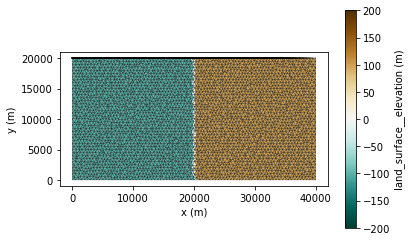

In [6]:
child.quick_plot(
    "land_surface__elevation", edgecolors="k", vmin=-200, vmax=200, cmap="BrBG_r"
)

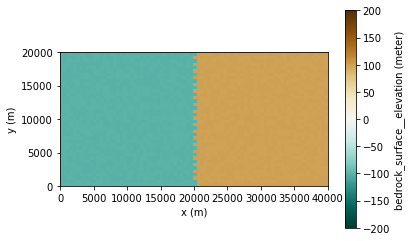

In [7]:
sedflux.quick_plot("bedrock_surface__elevation", vmin=-200, vmax=200, cmap="BrBG_r")

In [8]:
sedflux.set_value("channel_exit_water_flow__speed", 1.2)
sedflux.set_value("channel_exit_x-section__mean_of_width", 400.)
sedflux.set_value("channel_exit_x-section__mean_of_depth", 4.)

array([ 4.])

In [9]:
now = child.time
times = np.arange(now, now + 1000, 1.0)
sedflux.update()
child.update()

for t in times:
    child.update_until(t, units="years")

    sedflux.set_value("channel_water_sediment~bedload__mass_flow_rate", mapfrom=child)
    sedflux.update_until(t, units="years")

    z = child.get_value("land_surface__elevation")
    child.set_value(
        "land_surface__elevation",
        mapfrom=("land-or-seabed_sediment_surface__elevation", sedflux),
        nomap=np.where(z > 0.0),
    )

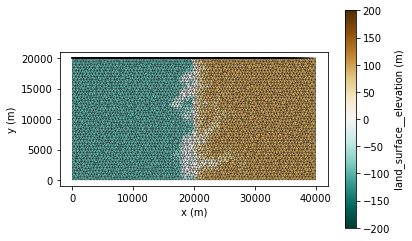

In [10]:
child.quick_plot(
    "land_surface__elevation", edgecolors="k", vmin=-200, vmax=200, cmap="BrBG_r"
)